# Case Study 2 - Fairness

## The Task
Train a fair prognostic classifier for COVID-19 patients in Brazil.

### Imports
Lets get the imports out of the way. We import the required standard and 3rd party libraries and relevant Synthcity modules. We can also set the level of logging here, using Synthcity's bespoke logger. 

In [1]:
# Standard
import sys
import warnings
from pathlib import Path
from typing import Any, Tuple
from pprint import pprint
import itertools

# 3rd party
import numpy as np
import pandas as pd
import networkx as nx
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, accuracy_score, confusion_matrix, ConfusionMatrixDisplay


# synthcity
import synthcity
import synthcity.logger as log
from synthcity.utils import serialization
from synthcity.plugins import Plugins
from synthcity.metrics import Metrics
from synthcity.plugins.core.dataloader import (GenericDataLoader, SurvivalAnalysisDataLoader)
from synthcity.plugins.privacy.plugin_decaf import plugin as decaf_plugin

# Synthetic-data-lab
from utils import fairness_scores

# Configure warnings and logging
warnings.filterwarnings("ignore")

# Set the level for the logging
log.remove()
# log.add(sink=sys.stderr, level="INFO")


# Set up paths to resources
FAIR_RES_PATH = Path("../resources/fairness/")

/home/rob/miniconda3/envs/synth-lab/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the data
Next, we can load the data from file and formulate it as a classification problem. To do this we can simply set a time horizon and create an "is_dead_at_time_horizon" column. 

In [2]:
time_horizon = 14
X = pd.read_csv(f"../data/Brazil_COVID/covid_normalised_numericalised.csv")

X.loc[(X["Days_hospital_to_outcome"] <= time_horizon) & (X["is_dead"] == 1), f"is_dead_at_time_horizon={time_horizon}"] = 1
X.loc[(X["Days_hospital_to_outcome"] > time_horizon), f"is_dead_at_time_horizon={time_horizon}"] = 0
X.loc[(X["is_dead"] == 0), f"is_dead_at_time_horizon={time_horizon}"] = 0
X[f"is_dead_at_time_horizon={time_horizon}"] = X[f"is_dead_at_time_horizon={time_horizon}"].astype(int)

X.drop(columns=["is_dead", "Days_hospital_to_outcome"], inplace=True) # drop survival columns as they are not needed for a classification problem
display(X)

# Define the mappings of the encoded values in the Ethnicity column to the understandable values
ethnicity_mapper = {
    0: "Mixed",
    1: "White",
    2: "Black",
    3: "East Asian",
    4: "Indigenous",
}

,Age,Sex,Ethnicity,Region,Fever,Cough,Sore_throat,Shortness_of_breath,Respiratory_discomfort,SPO2,...,Cardiovascular,Asthma,Diabetis,Pulmonary,Immunosuppresion,Obesity,Liver,Neurologic,Renal,is_dead_at_time_horizon=14
0,1,0,0,2,1,1,0,1,1,1,...,0,1,0,0,0,0,0,0,0,0
1,75,0,0,2,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,61,1,0,2,1,1,0,1,0,0,...,1,0,1,0,0,0,0,0,0,1
3,81,1,0,2,1,1,0,1,1,1,...,1,0,1,0,0,0,0,0,0,1
4,86,0,0,2,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6877,52,0,0,4,1,1,0,1,1,1,...,0,0,1,0,0,0,0,0,0,0
6878,34,1,1,4,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6879,44,1,1,4,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6880,23,1,1,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Potential issue

The Brazilian population is made up of people of different ethnicities in different proportions. We should check the frequency for each ethnicity to see how evenly distributed our data is across ethnicity. Lets create a plot.

AxesSubplot(0.125,0.11;0.775x0.77)


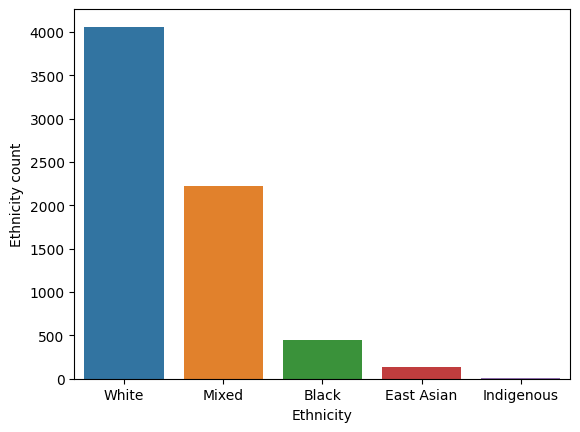

In [3]:
ethnicity_frequency_data = pd.DataFrame(data=X["Ethnicity"].value_counts().rename(ethnicity_mapper), columns=["Ethnicity"]).reset_index().rename(columns={"index": "Ethnicity", "Ethnicity": "Ethnicity count"})
print(sns.barplot(data=ethnicity_frequency_data, x="Ethnicity", y="Ethnicity count"))

The population in our dataset is overwhelmingly white an mixed, with little representation of black, East Asian and indigenous people. This poses a problem for us.

# The Problem
We need a prognostic classifier for the whole population. Having little representation from some parts of the population means that any classifier we train on this data is going to be susceptible to bias. Lets test an XGBoost classifier on the whole dataset then test it on each ethnicity. This will show us the extent of the problem, as we will be able to see any disparity between model performance across the different groups.

Set up the data splits using train_test_split from sklearn.

In [4]:
y = X["is_dead_at_time_horizon=14"]
X_in = X.drop(columns=["is_dead_at_time_horizon=14"])

X_train, X_test, y_train, y_test = train_test_split(X_in, y, random_state=4)
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

Load the trained xgboost classifier, which has been trained on the whole dataset.

In [5]:
# Define the model
xgb_model = xgb.XGBClassifier(
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=5,
    subsample=0.8, 
    colsample_bytree=1, 
    gamma=1, 
    objective="binary:logistic",
    random_state=42,
)

# Load the model trained on the whole dataset
saved_model_path = FAIR_RES_PATH / "fairness_cond_aug_xgboost_real_data.json"
xgb_model.load_model(saved_model_path)

# # The saved model was trained with the following code
# xgb_model.fit(X_train, y_train)
# xgb_model.save_model(saved_model_path)

Evaluate the accuracy of the classifier on the whole dataset. We can see the accuracy on both the train and test sets.

In [6]:
calculated_accuracy_score = accuracy_score(y_train, xgb_model.predict(X_train))
print(f"Evaluating accuracy on train set: {calculated_accuracy_score:0.4f}")

# Predicted values for whole dataset
y_pred = xgb_model.predict(X_test)

calculated_accuracy_score = accuracy_score(y_test, y_pred)
print(f"Evaluating accuracy on whole test set: {calculated_accuracy_score:0.4f}")

Evaluating accuracy on train set: 0.8126
Evaluating accuracy on whole test set: 0.7455


Create the confusion matrix for each of the ethnicities and the whole dataset to compare

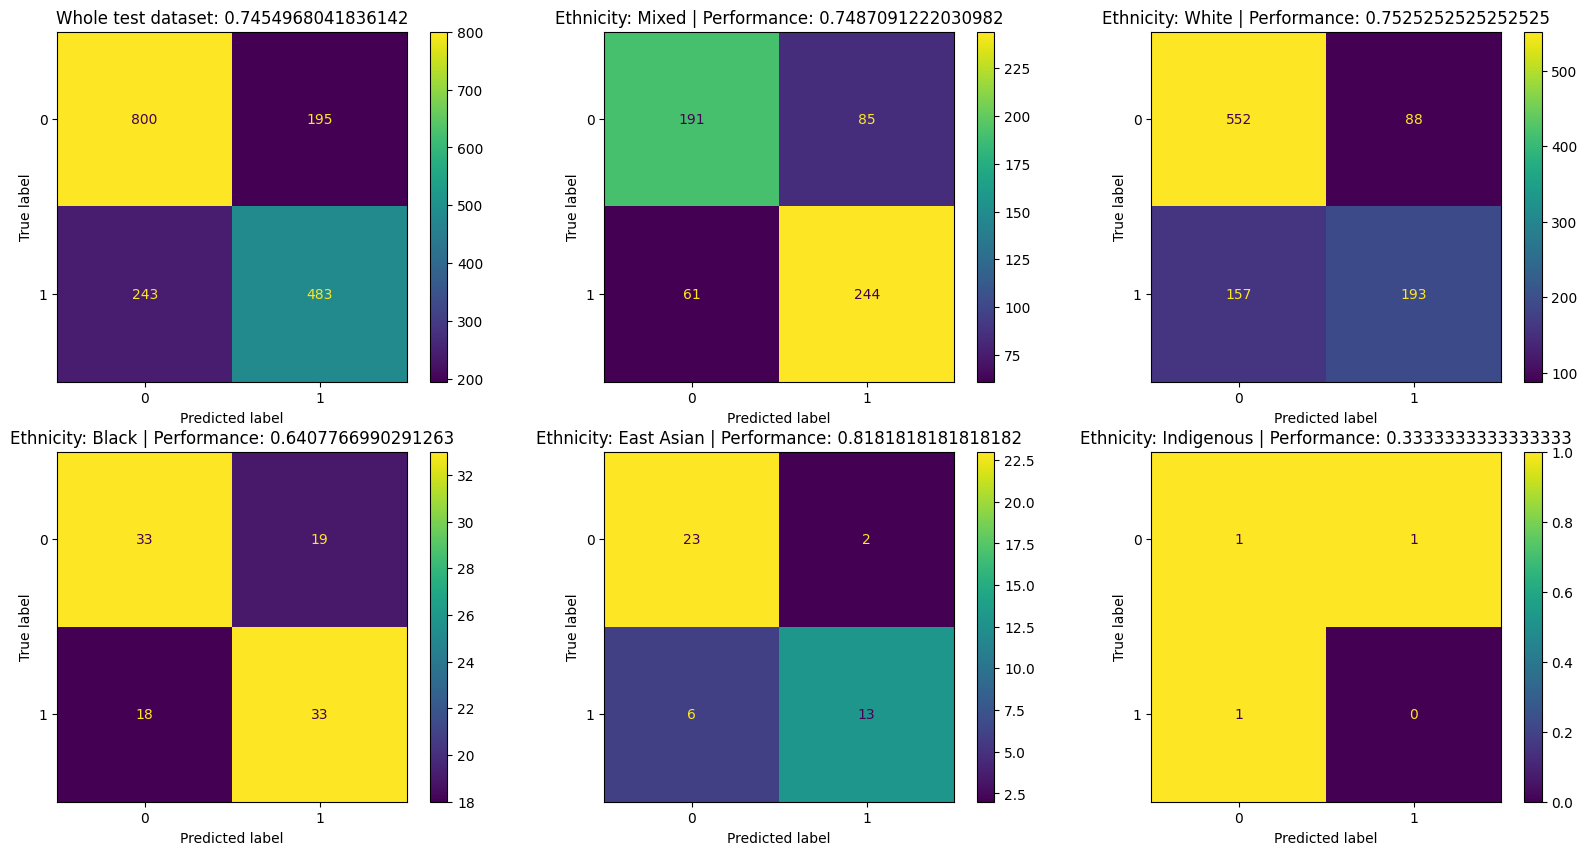

In [7]:
# Setup the figure axis
f, axes = plt.subplots(2, 3, figsize=(20, 10))

# Create the whole dataset confusion matrix and add it to the figure
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_model.classes_)
disp.plot(ax=axes[0,0])
disp.ax_.set_title(f"Whole test dataset: {calculated_accuracy_score}")

# Get the indices to loop through
ethnicity_idxes = X_in["Ethnicity"].unique()
ethnicity_idxes.sort()

# for each ethnicity create a confusion matrix
for ethnicity_idx in ethnicity_idxes:
    # Get the slice of the dataset for each ethnicity
    X_test_per_ethnicity = X_test.loc[X_test["Ethnicity"] == ethnicity_idx]
    test_records_per_ethnicity_indices = X_test_per_ethnicity.index
    y_true = y_test.iloc[test_records_per_ethnicity_indices]

    # Generate prediction values for each ethnicity subpopulation
    y_pred_per_ethnicity = xgb_model.predict(X_test_per_ethnicity)

    # Calculate the model performance for each ethnicity subpopulation
    calculated_accuracy_score = accuracy_score(y_true, y_pred_per_ethnicity)

    # Generate the confusion matrix and add it to the figure
    cm = confusion_matrix(y_true, y_pred_per_ethnicity)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_model.classes_)
    ax_index = [0, ethnicity_idx + 1] if ethnicity_idx <= 1 else [1, (ethnicity_idx + 1) % 3]
    disp.plot(ax=axes[ax_index[0], ax_index[1]])
    disp.ax_.set_title(f"Ethnicity: {ethnicity_mapper[ethnicity_idx]} | Performance: {calculated_accuracy_score}")
plt.show()

As you can see the performance of the model on the black population is significantly worse than the overall performance. Interestingly, however the model performs better on the East Asian subpopulation. This is likely to be due to random chance, i.e. it happens that the East Asian patients in this sample had features that are good predictors of the outcome, but this would not necessarily be true for a bigger sample from the same population. The Indigenous population is so poorly represented in the dataset, with only 3 records, that it is difficult to even accurately assess performance. However, the indication we have from these three records suggests performance may be poor.

This confirms by using a naive method like the one above, we would create a model that systematically performs worse for people of one ethnicity compared to another. This unfairness must be addressed.

# The solution - Augment the dataset to improve the fairness

First we load the data with the GenericDataLoader. For this we need to pass the names of our `target_column` to the data loader. Then we can see the data by calling loader.dataframe() and we could also get the infomation about the data loader object with loader.info().


In [8]:
loader = GenericDataLoader(
    X,
    target_column=f"is_dead_at_time_horizon={time_horizon}",
    sensitive_features=["Age", "Sex", "Ethnicity", "Region"],
    random_state=42,
)

display(loader.dataframe())

,Age,Sex,Ethnicity,Region,Fever,Cough,Sore_throat,Shortness_of_breath,Respiratory_discomfort,SPO2,...,Cardiovascular,Asthma,Diabetis,Pulmonary,Immunosuppresion,Obesity,Liver,Neurologic,Renal,is_dead_at_time_horizon=14
0,1,0,0,2,1,1,0,1,1,1,...,0,1,0,0,0,0,0,0,0,0
1,75,0,0,2,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,61,1,0,2,1,1,0,1,0,0,...,1,0,1,0,0,0,0,0,0,1
3,81,1,0,2,1,1,0,1,1,1,...,1,0,1,0,0,0,0,0,0,1
4,86,0,0,2,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6877,52,0,0,4,1,1,0,1,1,1,...,0,0,1,0,0,0,0,0,0,0
6878,34,1,1,4,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6879,44,1,1,4,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6880,23,1,1,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Generate the synthetic data
We are now going to generate synthetic data with a condition such that the new dataset is more balanced with regard to ethnicity. We will first define some values which we will use below.

In [24]:
model = "ctgan"
prefix = "fairness.conditional_augmentation"
random_state = 42

print(model)

ctgan


We will now either create and fit a synthetic data model then save that model to file, or load one we have already saved from file.

In [25]:
# Define saved model name
save_file = Path("saved_models") / f"{prefix}_{model}_numericalised_rnd={random_state}.bkp"

# Load if available
if Path(save_file).exists():
    syn_model = serialization.load_from_file(save_file)
# create and fit if not available
else:
    syn_model = Plugins().get(model, random_state=3)
    syn_model.fit(loader, cond=loader["Ethnicity"])
    serialization.save_to_file(save_file, syn_model)

 25%|██▍       | 499/2000 [01:24<04:14,  5.91it/s]


Use the synthetic data model to generate data using the `cond` argument to try and make the data as evenly distributed across ethnicity as possible.

In [36]:
count = 6882 # set the count equal to the number of rows in the original dataset for a fair comparison
cond = [(i % 5) for i in range(count)] # set cond to an equal proportion of each index to encourage an equal a split as possible
syn_data = syn_model.generate(count=count, cond=cond, random_state=42).dataframe()

display(syn_data)
print("Here is the ethnicity breakdown for the new synthetic dataset:")
print(syn_data["Ethnicity"].value_counts().rename(ethnicity_mapper))


,Age,Sex,Ethnicity,Region,Fever,Cough,Sore_throat,Shortness_of_breath,Respiratory_discomfort,SPO2,...,Cardiovascular,Asthma,Diabetis,Pulmonary,Immunosuppresion,Obesity,Liver,Neurologic,Renal,is_dead_at_time_horizon=14
0,69,1,0,2,1,1,0,1,1,1,...,1,0,0,0,0,0,0,0,0,1
1,72,1,1,4,1,1,1,1,1,1,...,1,0,0,0,0,0,0,0,0,1
2,37,1,2,4,1,1,1,1,0,1,...,0,1,1,0,0,0,0,0,0,0
3,65,1,3,1,1,1,0,1,1,1,...,0,0,1,0,0,0,0,0,1,1
4,36,1,2,4,1,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6877,70,1,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1
6878,86,1,0,4,0,1,0,1,1,1,...,1,0,1,0,0,0,0,0,0,1
6879,84,1,1,4,0,1,1,1,1,1,...,1,1,0,0,0,0,0,1,0,1
6880,63,1,2,4,0,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0


Here is the ethnicity breakdown for the new synthetic dataset:
White         2210
Mixed         1947
Black         1744
East Asian     913
Indigenous      68
Name: Ethnicity, dtype: int64


Check the ethnicity breakdown again now to check we have augmented the under-represented groups properly. This is important as the conditional only optimizes the GAN here it does not guarantee that generated samples perfectly meet that condition. If you require rules to be strictly adhered to, use `Constraints` instead. 

# Lets try our classifier again with the synthetic dataset
First we need to set up the synthetic data as we did before.

In [12]:
syn_y = syn_data["is_dead_at_time_horizon=14"]
syn_X_in = syn_data.drop(columns=["is_dead_at_time_horizon=14"])

syn_X_train, syn_X_test, syn_y_train, syn_y_test = train_test_split(syn_X_in, syn_y, random_state=4)
syn_X_train.reset_index(drop=True, inplace=True)
syn_X_test.reset_index(drop=True, inplace=True)
syn_y_train.reset_index(drop=True, inplace=True)
syn_y_test.reset_index(drop=True, inplace=True)


We need a model trained on the new data. We can load this from file, as before.

In [13]:
# Define the model
xgb_model = xgb.XGBClassifier(
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=5,
    subsample=0.8, 
    colsample_bytree=1, 
    gamma=1, 
    objective="binary:logistic",
    random_state=42,
)

# # Load the model trained on the whole dataset
saved_model_path = FAIR_RES_PATH / "fairness_cond_aug_xgboost_synthetic.json"
xgb_model.load_model(saved_model_path)

# # The saved model was trained with the following code
# xgb_model.fit(syn_X_train, syn_y_train)
# xgb_model.save_model(the_saved_model_path)


Evaluate the performance of the model on the whole synthetic dataset

In [14]:
calculated_accuracy_score = accuracy_score(syn_y_train, xgb_model.predict(syn_X_train))
print(f"evaluating train set: {calculated_accuracy_score}")

syn_y_pred = xgb_model.predict(syn_X_test)
calculated_accuracy_score = accuracy_score(syn_y_test, syn_y_pred)
print(f"evaluating test set: {calculated_accuracy_score}")

evaluating train set: 0.7919007944196861
evaluating test set: 0.800116211504939


Create the confusion matrix for the synthetic dataset

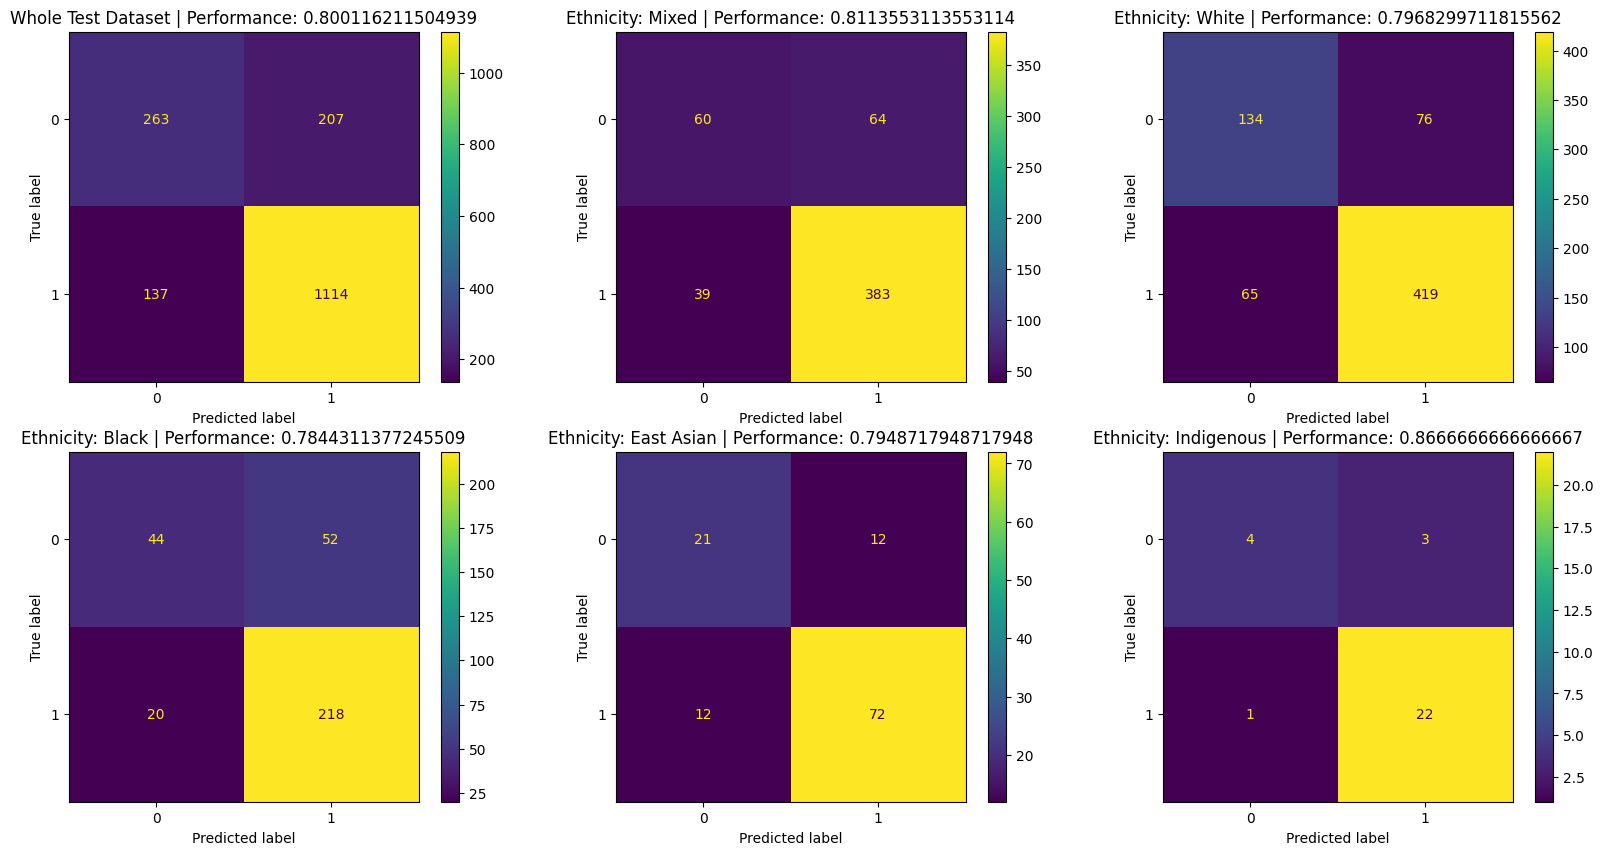

In [15]:

# Setup the figure axis
f, axes = plt.subplots(2, 3, figsize=(20, 10))

# Create the whole dataset confusion matrix and add it to the figure
cm = confusion_matrix(syn_y_test, syn_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_model.classes_)
disp.plot(ax=axes[0,0])
disp.ax_.set_title(f"Whole Test Dataset | Performance: {calculated_accuracy_score}")

# Get the indices to loop through
ethnicity_idxes = syn_X_in["Ethnicity"].unique()
ethnicity_idxes.sort()

# for each ethnicity create a confusion matrix
for ethnicity_idx in ethnicity_idxes:
    # Get the slice of the dataset for each ethnicity
    syn_X_test_per_ethnicity = syn_X_test.loc[syn_X_test["Ethnicity"] == ethnicity_idx]
    test_records_per_ethnicity_indicies = syn_X_test_per_ethnicity.index
    syn_y_true = syn_y_test.iloc[test_records_per_ethnicity_indicies]

    # Generate prediction values for each ethnicity subpopulation
    syn_y_pred = xgb_model.predict(syn_X_test_per_ethnicity)

    # Calculate the model performance for each ethnicity subpopulation
    calculated_accuracy_score = accuracy_score(syn_y_true, syn_y_pred)

    # Generate the confusion matrix and add it to the figure
    cm = confusion_matrix(syn_y_true, syn_y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_model.classes_)
    ax_index = [0, ethnicity_idx + 1] if ethnicity_idx <= 1 else [1, (ethnicity_idx + 1) % 3]
    disp.plot(ax=axes[ax_index[0], ax_index[1]])
    disp.ax_.set_title(f"Ethnicity: {ethnicity_mapper[ethnicity_idx]} | Performance: {calculated_accuracy_score}")
plt.show()

As you can hopefully see the new model trained on the synthetic data performs more similarly across the different populations. 

Why not play with the different synthetic data generation methods and their parameters to see if you can achieve the same improvement in fairness, but with a higher performance? If you need help identifying the right methods then, remember you can list the available plugins with `Plugins().list()` and to learn what they do refer to the [docs](https://synthcity.readthedocs.io/en/latest/generators.html).

# Removing bias via causal generation with DECAF
### Load the data
Lets load the data from file again to make sure we are working with the correct data and nothing has changed. As before we will construct it as a classification problem.

In [16]:
# Load the data from file
X = pd.read_csv(f"../data/Brazil_COVID/covid_normalised_numericalised.csv")
# Set it up as classification task
time_horizon = 14
X.loc[(X["Days_hospital_to_outcome"] <= time_horizon) & (X["is_dead"] == 1), f"is_dead_at_time_horizon={time_horizon}"] = 1
X.loc[(X["Days_hospital_to_outcome"] > time_horizon), f"is_dead_at_time_horizon={time_horizon}"] = 0
X.loc[(X["is_dead"] == 0), f"is_dead_at_time_horizon={time_horizon}"] = 0
X[f"is_dead_at_time_horizon={time_horizon}"] = X[f"is_dead_at_time_horizon={time_horizon}"].astype(int)

X.drop(columns=["is_dead", "Days_hospital_to_outcome"], inplace=True) # drop survival columns as they are not needed for a classification problem

Pass the data into the synthcity dataloader. We will just use the `GenericDataloader` here.

In [17]:

loader = GenericDataLoader(
    X,
    target_column="is_dead_at_time_horizon=14",
    sensitive_features=["Ethnicity"],
    # sensitive_features=["Age", "Sex", "Ethnicity", "Region"], # How to handle multiple sensitive columns?
    random_state=42,
)

display(loader.dataframe())

,Age,Sex,Ethnicity,Region,Fever,Cough,Sore_throat,Shortness_of_breath,Respiratory_discomfort,SPO2,...,Cardiovascular,Asthma,Diabetis,Pulmonary,Immunosuppresion,Obesity,Liver,Neurologic,Renal,is_dead_at_time_horizon=14
0,1,0,0,2,1,1,0,1,1,1,...,0,1,0,0,0,0,0,0,0,0
1,75,0,0,2,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,61,1,0,2,1,1,0,1,0,0,...,1,0,1,0,0,0,0,0,0,1
3,81,1,0,2,1,1,0,1,1,1,...,1,0,1,0,0,0,0,0,0,1
4,86,0,0,2,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6877,52,0,0,4,1,1,0,1,1,1,...,0,0,1,0,0,0,0,0,0,0
6878,34,1,1,4,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6879,44,1,1,4,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6880,23,1,1,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Create and fit syn_model using DECAF
First, we define some useful variables.

In [18]:
prefix = "fairness.causal_generation"
model = "decaf"
n_iter = 20
count = 6882 # set the count equal to the number of rows in the original dataset
random_state=42
print(model)

decaf


Then load the synthetic model from file. If you want to try something a little different you can also fit your own model.

In [19]:

# Define saved model name
save_file = Path("saved_models") / f"{prefix}_{model}_n_iter={n_iter}_rnd={random_state}.bkp"

# Load from file if available
if Path(save_file).exists():
    syn_model = serialization.load_from_file(save_file)
    print(f"DAG before biased edges are removed:\n{syn_model.get_dag(loader.dataframe())}")
    
# create and fit if not available
else:
    syn_model = decaf_plugin(struct_learning_enabled=True, n_iter=n_iter, random_state=random_state) # Pass struct_learning_enabled=True in order for the syn_model to learn the Dag
    dag_before = syn_model.get_dag(loader.dataframe())
    syn_model.fit(loader, dag=dag_before)
    serialization.save_to_file(save_file, syn_model)
    print(f"DAG before biased edges are removed:\n{syn_model.get_dag(loader.dataframe())}")

DAG before biased edges are removed:
[('Age', 'is_dead_at_time_horizon=14'), ('Age', 'Cardiovascular'), ('Age', 'Diabetis'), ('Age', 'Region'), ('Age', 'Neurologic'), ('Age', 'Sex'), ('Age', 'Renal'), ('Age', 'Fever'), ('Age', 'Pulmonary'), ('Age', 'Obesity'), ('Age', 'Vomitting'), ('Age', 'Asthma'), ('Age', 'Immunosuppresion'), ('Age', 'Liver'), ('is_dead_at_time_horizon=14', 'SPO2'), ('Region', 'Ethnicity'), ('Region', 'Sore_throat'), ('Fever', 'Cough'), ('Vomitting', 'Dihareea'), ('SPO2', 'Respiratory_discomfort'), ('Respiratory_discomfort', 'Shortness_of_breath')]


Now we can simply generate the debiased dataset, by passing the biased edges we wish to remove from the data to `generate`.

In [20]:
bias={"Ethnicity": ["is_dead_at_time_horizon=14"]} # This will probably need to be column indices
decaf_syn_data = syn_model.generate(count, biased_edges=bias, random_state=random_state)
display(decaf_syn_data.dataframe())
print(f"DAG after biased edges are removed:\n{syn_model.get_dag(decaf_syn_data.dataframe())}")

,Age,Sex,Ethnicity,Region,Fever,Cough,Sore_throat,Shortness_of_breath,Respiratory_discomfort,SPO2,...,Cardiovascular,Asthma,Diabetis,Pulmonary,Immunosuppresion,Obesity,Liver,Neurologic,Renal,is_dead_at_time_horizon=14
0,64,1,1,4,1,1,0,1,0,0,...,1,0,1,1,0,1,0,0,1,0
1,38,1,1,4,0,1,0,0,1,1,...,0,0,0,0,1,0,0,0,0,1
2,41,0,1,4,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,83,1,1,4,0,1,0,0,1,1,...,1,0,0,0,0,0,0,0,0,0
4,32,1,1,4,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6877,46,1,1,4,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
6878,31,0,1,4,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
6879,65,1,1,4,1,1,0,1,0,1,...,1,0,1,0,1,0,0,0,0,1
6880,81,1,1,4,1,1,0,0,1,1,...,0,0,0,0,1,0,0,1,0,1


DAG after biased edges are removed:
[('Age', 'Cardiovascular'), ('Age', 'Fever'), ('Age', 'Pulmonary'), ('Age', 'Neurologic'), ('Age', 'Renal'), ('Age', 'Sex'), ('Age', 'Obesity'), ('Age', 'Ethnicity'), ('Cardiovascular', 'Diabetis'), ('Cardiovascular', 'is_dead_at_time_horizon=14'), ('Diabetis', 'Liver'), ('Diabetis', 'Vomitting'), ('is_dead_at_time_horizon=14', 'SPO2'), ('is_dead_at_time_horizon=14', 'Region'), ('is_dead_at_time_horizon=14', 'Immunosuppresion'), ('SPO2', 'Respiratory_discomfort'), ('Respiratory_discomfort', 'Shortness_of_breath')]


## DECAF fairness tests

We will now check our synthetic data is fairer than the original, real data, by measuring fairness through unawareness and demographic parity. Definitions of these methods can be seen in section 4.1 of the [DECAF paper](https://arxiv.org/abs/2110.12884) for more information.

In [21]:
FTU_score_gt = fairness_scores.FTU_score(loader)
FTU_score_syn = fairness_scores.FTU_score(decaf_syn_data)

print(f"Fairness through unawareness scores \nreal data: {FTU_score_gt} | synthetic data: {FTU_score_syn}")

demographic_parity_score_gt = fairness_scores.demographic_parity_score(loader)
demographic_parity_score_syn = fairness_scores.demographic_parity_score(decaf_syn_data)

print(f"Demographic Parity scores \nreal data: {demographic_parity_score_gt} | synthetic data: {demographic_parity_score_syn}")

Fairness through unawareness scores 
real data: 0.01834362513621504 | synthetic data: 0.05993461678169265
Demographic Parity scores 
real data: 0.14552510430923596 | synthetic data: 0.6186484670819592


# Some visualizations